# Data From
https://github.com/Anand-GitH/TweetSentiAnalysis/tree/master/TweetSentiAnalysis

In [2]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from sqlalchemy import create_engine

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

import plotly.express as px
import plotly.graph_objects as go

# Set the random seed so things are reproducible
random_state = 42

# 2.1 Source the Data

In [3]:
#import the sql database with the polars function
conn = create_engine("sqlite:////home/troy/ml/project1/SentimentAnalysis.db")

#SQL query to get the date, close price, prev_close and sentiment score from the Database
new_query = """
SELECT 
    TS.Date AS StockDate,
    TS.Close AS StockClosingPrice,
    LAG(TS.Close) OVER (ORDER BY TS.Date) AS Prev_Close, 
    AVG(CASE 
            WHEN Score_Polarity = 'neutral' THEN 0
            ELSE T.Score
        END) AS TweetScore 
FROM 
    Tesla_Stock TS
JOIN 
    Tweet_data TD
ON 
    DATE(TS.Date) = DATE(TD.Creation_dt)
JOIN 
    Tweet_Scores T
ON 
    TD.ID = T.ID
GROUP BY TS.Date;  -- Ensure only one row per date

"""

df = pl.read_database(query=new_query, connection=conn)
df

#We are concerned about stockDate, StockClosingPrice, PreviousStockClosingPrice and TweetScore
#We will use the stockClosingPrice as the target variable and the TweetScore and Prev_Close as the feature variables
#We will use the date as the index
X = np.column_stack((df['TweetScore'], df['Prev_Close']))
y = np.array(df['StockClosingPrice'])
df = df.with_columns(pl.col("StockDate").str.strptime(pl.Date, "%Y-%m-%d"))
date = np.array(df['StockDate'])
# Get rid of first data point because it has a NaN value
X = X[1:]
y = y[1:]
date = date[1:]




# 2.2 Test Set

In [4]:
#Set aside 10% of the data for testing. This test will be used to compare the final perfrormace of all the models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)


# 2.5 Dummy Regressor

Sanity check baseline model error: 4829.487878813719
Mean Squared Error: 6020.52639531894


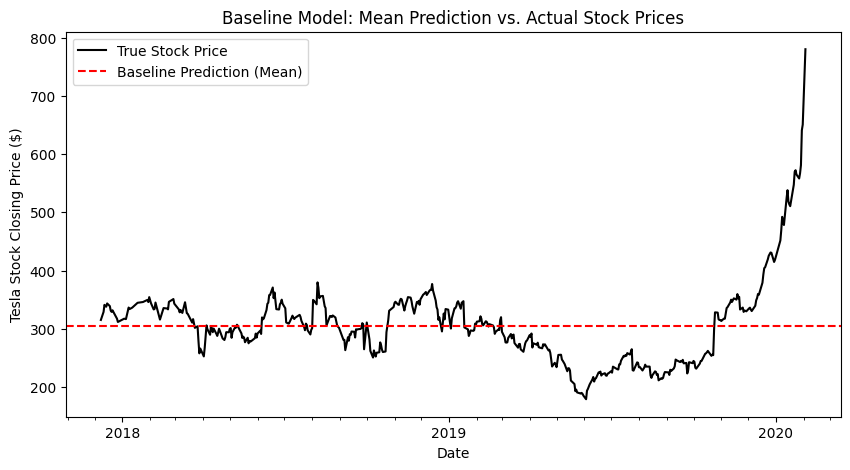

In [5]:
#Chose and train a baseline model as a sanity check.
dummy = DummyRegressor(strategy='mean')
dummy_scores = -cross_val_score(dummy, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("Sanity check baseline model error:",  dummy_scores.mean())

#train dummy model and plot the results with the date on the x-axis
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)

# print MSE error on final
dummy_mse = mean_squared_error(y_test, dummy_pred)
print("Mean Squared Error:", dummy_mse)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Plot actual stock prices
ax.plot(date, y, label="True Stock Price", color="black")
# Plot dummy model prediction (constant mean line)
ax.axhline(y_train.mean(), color="red", linestyle="dashed", label="Baseline Prediction (Mean)")
# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Tesla Stock Closing Price ($)")
ax.set_title("Baseline Model: Mean Prediction vs. Actual Stock Prices")
ax.legend()
# Formatting date axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.show()


# 2.6 K-Nearest-Neighbors

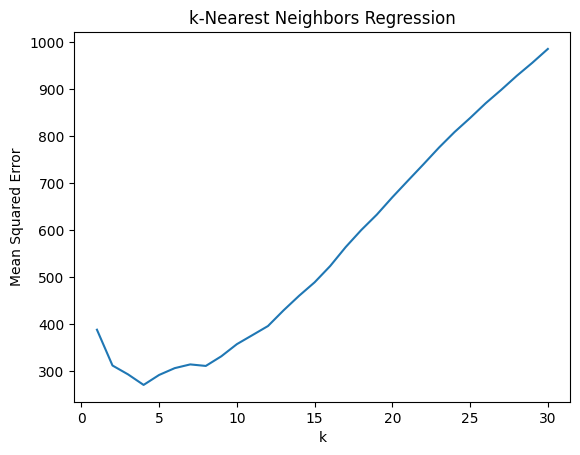

Best k value: 4
Best k value score: 270.5485565096754
k-Nearest Neighbors Regression MSE: 317.4011701250002


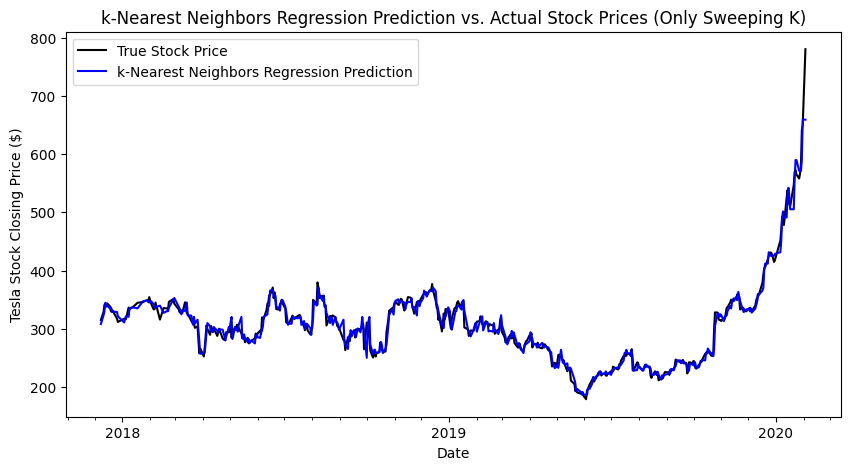

In [6]:
#Use k-Nearest-Neighbors regression to predict the stock price
#Perform a hyperparameter sweep to find the best k value
k_sweep = range(1, 30+1)
k_scores = []
#Loop through the hyperparameters
for k in k_sweep:
    pipe = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=k) )
    knn_scores = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    k_scores.append(knn_scores.mean())

#Create a plot with hyperparameters vs the estimated results of Enew
plt.plot(k_sweep, k_scores)
plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('k-Nearest Neighbors Regression')
plt.show()

#Find to hyperparameter that gives the best result
best_k = k_sweep[np.argmin(k_scores)]
print("Best k value:", best_k)
print("Best k value score:", min(k_scores))

#Train the final model with the best hyperparameter
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

knn_mse = mean_squared_error(y_test, knn_pred)
print("k-Nearest Neighbors Regression MSE:", knn_mse)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Plot actual stock prices
ax.plot(date, y, label="True Stock Price", color="black")
# Plot results of the k-Nearest Neighbors Regression
ax.plot(date, knn.predict(X), label="k-Nearest Neighbors Regression Prediction", color="blue")
# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Tesla Stock Closing Price ($)")
ax.set_title("k-Nearest Neighbors Regression Prediction vs. Actual Stock Prices (Only Sweeping K)")
ax.legend()
# Formatting date axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.show()


Best hyperparameters: (8, 'euclidean', 'distance', 253.51843857203409)


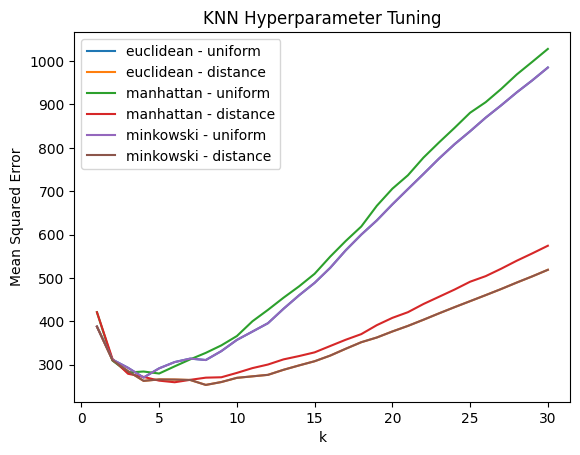

k-Nearest Neighbors Regression MSE: 271.0015112066419


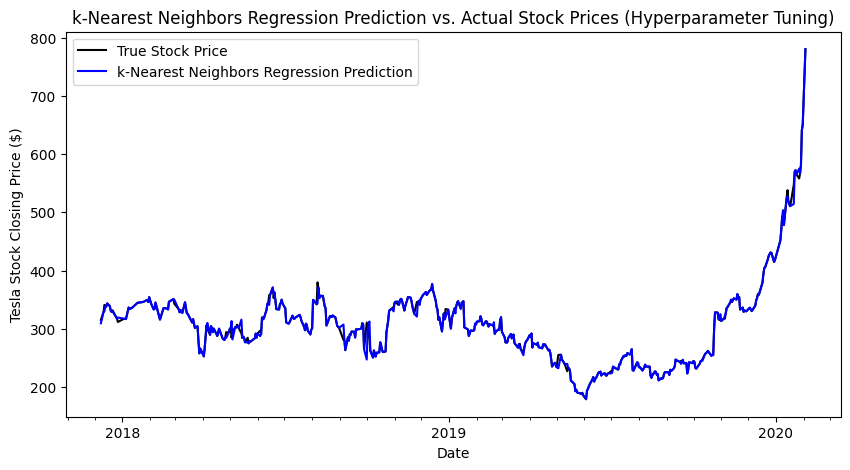

In [ ]:
# Define the hyperparameter grid
k_sweep = range(1, 30+1)
metrics = ['euclidean', 'manhattan', 'minkowski']
weight_list = ['uniform', 'distance']
results = []

# #Loop through the hyperparameters
for k in k_sweep:
    for metric in metrics:
        for weights in weight_list:
            pipe = make_pipeline(StandardScaler(), 
                                 KNeighborsRegressor(n_neighbors=k, metric=metric, weights=weights))
            knn_scores = -cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
            results.append((k, metric, weights, knn_scores.mean()))

# Convert to Polars DataFrame
results_df = pl.DataFrame(results, schema=["k", "metric", "weights", "MSE"], orient="row")

# Find best hyperparameter combination
best_index = results_df["MSE"].arg_min()
best_params = results_df.sort("MSE").row(0) 
print("Best hyperparameters:", best_params)
best_k = best_params[0]  # k value
best_metric = best_params[1]  # Distance metric
best_weights = best_params[2]  
# Plot results for different metrics and weighting schemes
for metric in metrics:
    for weights in weight_list:
        subset = results_df.filter((pl.col("metric") == metric) & (pl.col("weights") == weights))
        plt.plot(subset["k"], subset["MSE"], label=f'{metric} - {weights}')

plt.xlabel('k')
plt.ylabel('Mean Squared Error')
plt.title('KNN Hyperparameter Tuning')
plt.legend()
plt.show()

#Train the final model with the best hyperparameter
knn_best = KNeighborsRegressor(n_neighbors=best_k, metric=best_metric, weights=best_weights)
knn_best.fit(X_train, y_train)
knn_pred = knn_best.predict(X_test)

#Print the final results
knn_mse = mean_squared_error(y_test, knn_pred)
print("k-Nearest Neighbors Regression MSE:", knn_mse)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Plot actual stock prices
ax.plot(date, y, label="True Stock Price", color="black")
# Plot results of the k-Nearest Neighbors Regression
ax.plot(date, knn_best.predict(X), label="k-Nearest Neighbors Regression Prediction", color="blue")
# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Tesla Stock Closing Price ($)")
ax.set_title("k-Nearest Neighbors Regression Prediction vs. Actual Stock Prices (Hyperparameter Tuning)")
ax.legend()
# Formatting date axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.show()


# 2.7 Decision Trees

Best hyperparameters: (3, 1, 'squared_error', 197.0755940867195, 5)
Best error: 197.0755940867195
Best depth: 5
Best min_samples_split: 3
Best min_samples_leaf: 1
Best criterion: squared_error


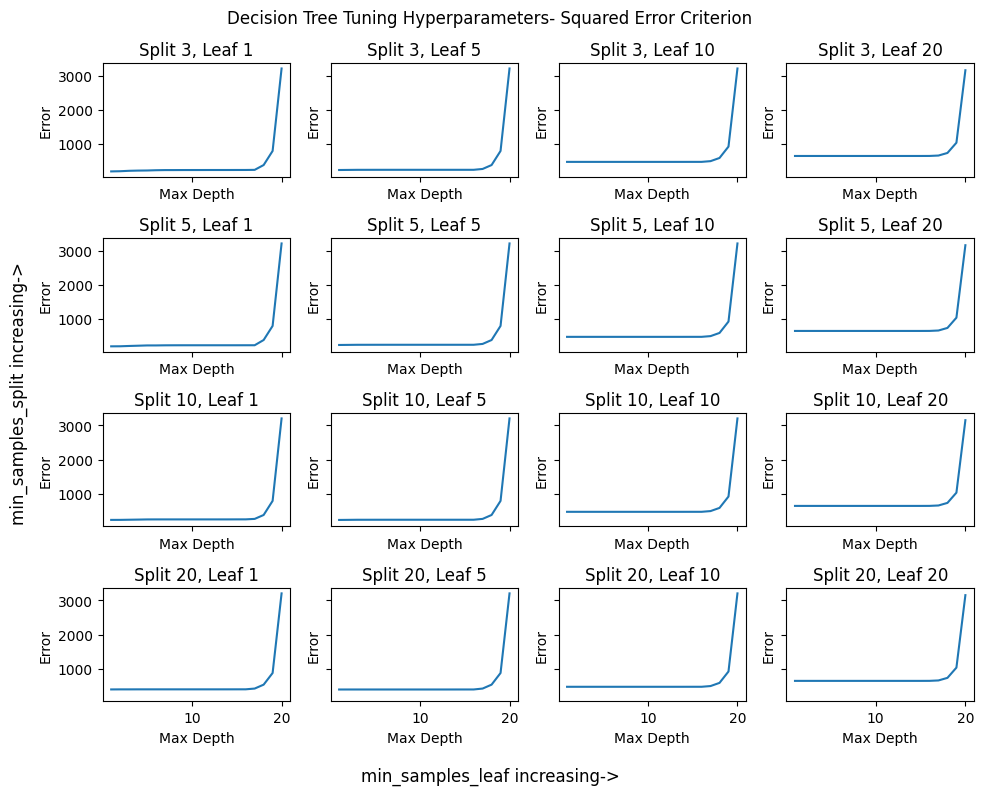

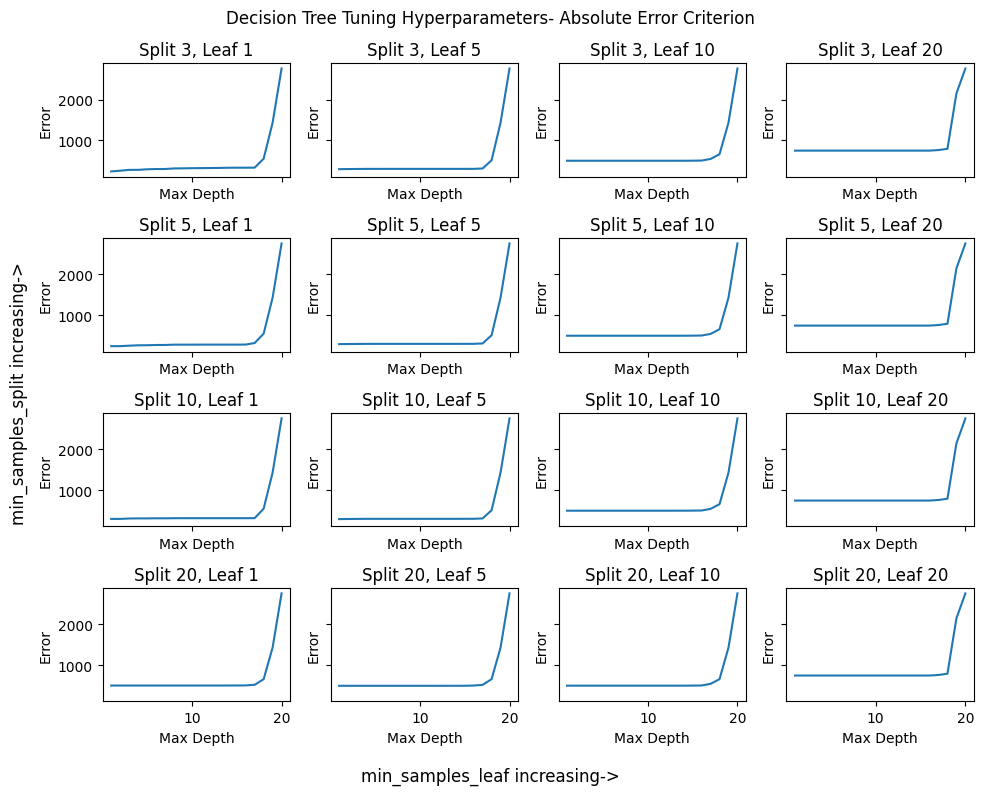

In [8]:
# Define the hyperparameter grid
criterion = ['squared_error', 'absolute_error']
depth_sweep = range(1, 20+1)
min_samples_split_vals = [3, 5, 10, 20]
min_samples_leaf_vals = [1, 5, 10, 20]

results = []

# #Loop through the hyperparameters
for c in criterion:
    for min_samples_split in min_samples_split_vals:
        for min_samples_leaf in min_samples_leaf_vals:
            for depth in depth_sweep:
                dt = DecisionTreeRegressor(max_depth=depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state = random_state, criterion=c)
                dt_scores = -cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error')
                results.append((min_samples_split, min_samples_leaf, c, dt_scores.mean(), depth))

# Convert to Polars DataFrame
results_df = pl.DataFrame(results, schema=["min_samples_split", "min_samples_leaf", "criterion", "MSE", "depth"], orient="row")

# Find best hyperparameter combination
best_index = results_df["MSE"].arg_min()
best_params = results_df.sort("MSE").row(0) 
print("Best hyperparameters:", best_params)
best_min_samples_split = best_params[0]  # min_samples_split value
best_min_samples_leaf = best_params[1]  # min_samples_leaf value
best_criterion = best_params[2]  # criterion value
best_error = best_params[3]  # best error value
best_depth_num = best_params[4]  # best depth value
print("Best error:", best_error)
print("Best depth:", best_depth_num)
print("Best min_samples_split:", best_min_samples_split)
print("Best min_samples_leaf:", best_min_samples_leaf)
print("Best criterion:", best_criterion)


# Create two separate plots, one for each criterion
fig1, axes1 = plt.subplots(len(min_samples_split_vals), len(min_samples_leaf_vals), figsize=(10, 8), sharex=True, sharey=True)
fig2, axes2 = plt.subplots(len(min_samples_split_vals), len(min_samples_leaf_vals), figsize=(10, 8), sharex=True, sharey=True)

fig1.suptitle("Decision Tree Tuning Hyperparameters- Squared Error Criterion")
fig2.suptitle("Decision Tree Tuning Hyperparameters- Absolute Error Criterion")
fig1.supxlabel("min_samples_leaf increasing->")
fig1.supylabel("min_samples_split increasing->")
fig2.supxlabel("min_samples_leaf increasing->")
fig2.supylabel("min_samples_split increasing->")

# Loop through each criterion separately
for c, fig, axes in zip(criterion, [fig1, fig2], [axes1, axes2]): # self note use zip to loop through two lists at same time
    for i, min_samples_split in enumerate(min_samples_split_vals):
        for j, min_samples_leaf in enumerate(min_samples_leaf_vals):
            # Filter data for current criterion/hyperparameter
            subset = results_df.filter(
                (pl.col("criterion") == c) & 
                (pl.col("min_samples_split") == min_samples_split) & 
                (pl.col("min_samples_leaf") == min_samples_leaf)
            )

            subset = subset.sort("MSE")# Sorted by depth before plotting

            # Plot results in subplot
            axes[i, j].plot(depth_sweep, subset["MSE"].to_list(), label=f"Split {min_samples_split}, Leaf {min_samples_leaf}")
            axes[i, j].set_title(f"Split {min_samples_split}, Leaf {min_samples_leaf}")
            axes[i, j].set_xlabel("Max Depth")
            axes[i, j].set_ylabel("Error")

# Fix overlapping labels
fig1.tight_layout()
fig2.tight_layout()
plt.show()

Decision Tree Regression MSE: 237.72985928961202


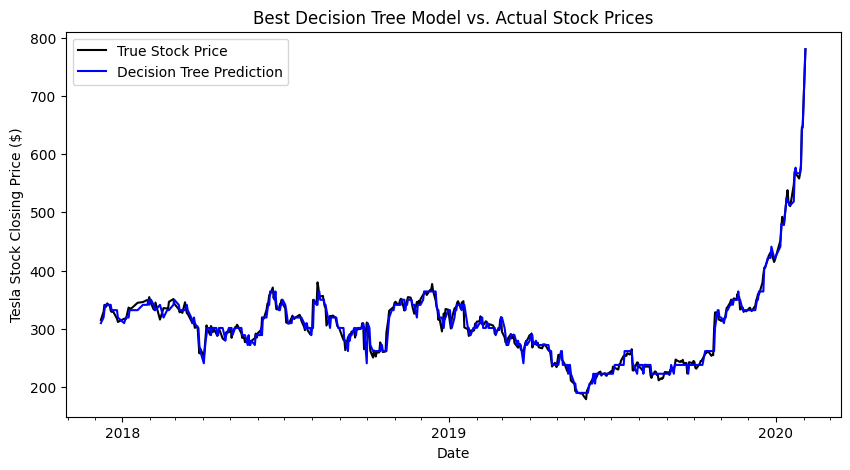

In [9]:
# Train the final model on the full training set using the best hyperparameters
best_decision = DecisionTreeRegressor(max_depth=best_depth_num, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, criterion=best_criterion, random_state=random_state)
best_decision.fit(X_train, y_train)
# Evaluate the final model
decision_pred = best_decision.predict(X_test)

decision_mse = mean_squared_error(y_test, decision_pred)
print("Decision Tree Regression MSE:", decision_mse)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Plot actual stock prices
ax.plot(date, y, label="True Stock Price", color="black")
# Plot results of the k-Nearest Neighbors Regression
ax.plot(date, best_decision.predict(X), label="Decision Tree Prediction", color="blue")
# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Tesla Stock Closing Price ($)")
ax.set_title("Best Decision Tree Model vs. Actual Stock Prices")
ax.legend()
# Formatting date axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.show()

# 2.8 Preformance Evaluation

In [10]:
#Print the final results
print("Dummy Model MSE:", dummy_mse)
print("KNN Model MSE:", knn_mse)
print("Decision Tree Model MSE:", decision_mse)

# Create the plot showing the MSE of all models as a bar chart
models = ["Dummy", "KNN", "Decision Tree"]
mse_values = [dummy_mse, knn_mse, decision_mse]
#Create bar chart with plotly
fig = px.bar(x=models, y=mse_values, labels={'x': 'Model', 'y': 'Mean Squared Error'}, title='Mean Squared Error of Different Models')
fig.show()




Dummy Model MSE: 6020.52639531894
KNN Model MSE: 271.0015112066419
Decision Tree Model MSE: 237.72985928961202


# 3.1-3.2 Model Analysis

In [11]:
dec_pred = best_decision.predict(X)
knn_best = knn.predict(X)
baseline = dummy.predict(X)

#error calculation MAE (not what the project asked but i wanted to know)
dummy_mae = mean_absolute_error(y, baseline)
knn_mae = mean_absolute_error(y, knn_best)
dec_mae = mean_absolute_error(y, dec_pred)
print("Dummy Model MAE:", dummy_mae)
print("KNN Model MAE:", knn_mae)
print("Decision Tree Model MAE:", dec_mae)


# Plot the comparisons in plotly 
fig = px.line(x=date, y=y, title="Predicted Daily Price vs. Date", labels={'y': 'Stock Closing Price', 'x': 'Date'})
fig.add_scatter(x=date, y=y , mode='lines', name="Actual Daily Price")
fig.add_scatter(x=date, y=baseline, mode='lines', name="Baseline Model")
fig.add_scatter(x=date, y=dec_pred, mode='lines', name="Decision Tree ")
fig.add_scatter(x=date, y=knn_best, mode='lines', name="k-Nearest Neighbors")
fig.show()

Dummy Model MAE: 47.86407685486522
KNN Model MAE: 7.424341046277665
Decision Tree Model MAE: 7.108317024715092


In [12]:
# Calculate residuals (differences) between predictions and actual stock price
residual_knn = knn_best - y
residual_decision = dec_pred - y

# Create a Plotly figure
fig = go.Figure()

# Add residuals for KNN Model
fig.add_trace(go.Bar(x=date, y=residual_knn, name="KNN Model Residuals",
                     marker=dict(color='blue', opacity=0.9, line=dict(width=1.5, color='blue'))))

# Add residuals for Decision Tree Model
fig.add_trace(go.Bar(x=date, y=residual_decision, name="Decision Tree Residuals",
                     marker=dict(color='red', opacity=0.9, line=dict(width=1.5, color='red'))))

# Update layout
fig.update_layout(title="Stock Price Prediction Residuals (without Baseline Model)",
                  xaxis_title="Date",
                  yaxis_title="Prediction Error (in USD $)",
                  legend_title="Model",
                  barmode="relative",  
                  template="plotly_white")

# Show the figure
fig.show()

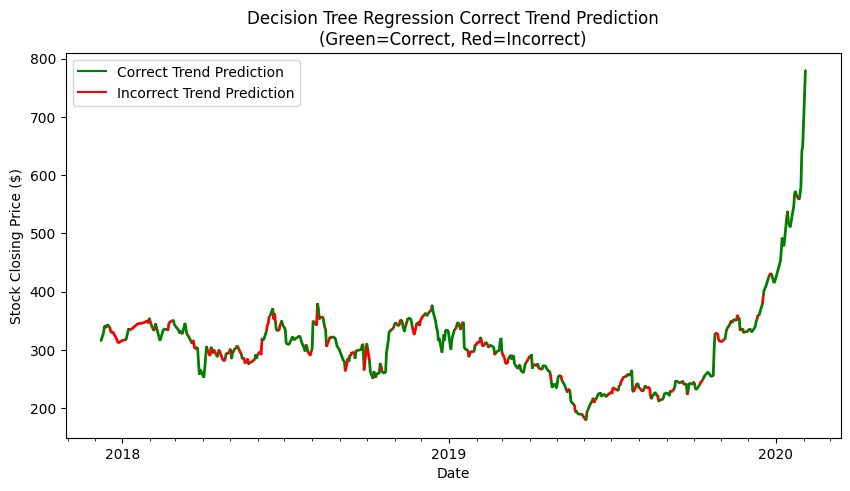

Correct Percentage: 61.09%


In [13]:
# Sort values chronologically
sorted_indices = np.argsort(date)
date, y, dt_pred = date[sorted_indices], y[sorted_indices], dec_pred[sorted_indices]

# Compute trend correctness (Green = Correct, Red = Incorrect)
colors = []
segments = []

for i in range(1, len(date)):
    actual_trend = y[i] - y[i-1]
    predicted_trend = dt_pred[i] - y[i-1]
    color = "green" if np.sign(actual_trend) == np.sign(predicted_trend) else "red"
    colors.append(color)
    segments.append([(date[i-1], y[i-1]), (date[i], y[i])])

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
# True stock price line
ax.plot(date, y, color="black", linewidth=1)

# Prediction line with colored correctness
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Stock Closing Price ($)")
ax.set_title(f"Decision Tree Regression Correct Trend Prediction\n(Green=Correct, Red=Incorrect)")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.plot([], color='green', label='Correct Trend Prediction')# manual legend
ax.plot([], color='red', label='Incorrect Trend Prediction')
ax.legend()
plt.show()

# Find the percentage it is correct
correct = np.array(colors) == "green"
correct_percentage = np.sum(correct) / len(colors) * 100
print(f"Correct Percentage: {correct_percentage:.2f}%")


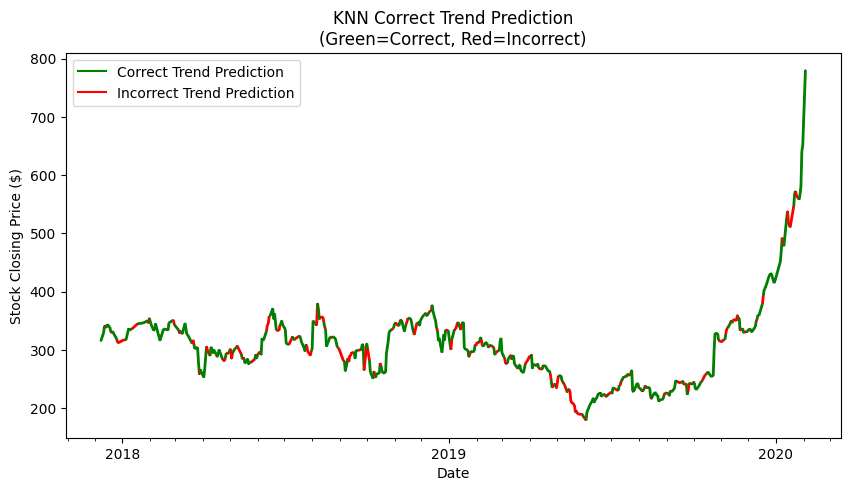

Correct Percentage: 65.93%


In [14]:
#Sorry, i just coppied the code and changed the variable to produce the results for KNN
# Sort values chronologically
sorted_indices = np.argsort(date)
date, y, dt_pred = date[sorted_indices], y[sorted_indices], knn_best[sorted_indices]

# Compute trend correctness (Green = Correct, Red = Incorrect)
colors = []
segments = []

for i in range(1, len(date)):
    actual_trend = y[i] - y[i-1]
    predicted_trend = dt_pred[i] - y[i-1]
    color = "green" if np.sign(actual_trend) == np.sign(predicted_trend) else "red"
    colors.append(color)
    segments.append([(date[i-1], y[i-1]), (date[i], y[i])])

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
# True stock price line
ax.plot(date, y, color="black", linewidth=1)

# Prediction line with colored correctness
lc = LineCollection(segments, colors=colors, linewidth=2)
ax.add_collection(lc)

# Formatting
ax.set_xlabel("Date")
ax.set_ylabel("Stock Closing Price ($)")
ax.set_title(f"KNN Correct Trend Prediction\n(Green=Correct, Red=Incorrect)")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.plot([], color='green', label='Correct Trend Prediction')# manual legend
ax.plot([], color='red', label='Incorrect Trend Prediction')
ax.legend()
plt.show()

# Find the percentage it is correct
correct = np.array(colors) == "green"
correct_percentage = np.sum(correct) / len(colors) * 100
print(f"Correct Percentage: {correct_percentage:.2f}%")
